# Experimentos y análisis


In [52]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Número de células evaluadas por segundo para varios tamaños de grilla $N \times M$

Variar el tamaño de la grilla con `block/local size` fijos, 1000 iteraciones y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{10}$ a $2^{28}$ (incrementos de 2). De esta manera se usa de $2*1$ KB hasta $2*2^{8}$ MB de memoria ($0.5$ GB) (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [4]:
current_path = os.getcwd()
block = 32
iterations = 1000

for i in range(10, 29, 2):
    N = 2**(i/2)
    M = 2**(i/2)
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>    <output_file>               <0|1 (if)>
        # subprocess.run([CPU_EXEC,   str(N),         str(M),         iterations,     current_path + "/cpu.csv",  str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        # subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),              str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

Running for size 1024.0
Running for size 4096.0
Running for size 16384.0
Running for size 65536.0
Running for size 262144.0
Running for size 1048576.0
Running for size 4194304.0
Running for size 16777216.0
Running for size 67108864.0
Running for size 268435456.0


### Análisis

In [44]:
# read from csv and add correct columns
cpu = pd.read_csv("cpu.csv", header=None)
cl = pd.read_csv("cl.csv", header=None)
cuda = pd.read_csv("cuda.csv", header=None)

cpu.columns = ["size", "data creation time", "execution time", "total time"]
cl.columns = ["size", "local size", "if use", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu)
print("CL")
print(cl)
print("CUDA")
print(cuda)

CPU
       size  data creation time  execution time  total time
0        32                   2               0           2
1        32                   2               0           2
2        32                   2               0           2
3        32                   2               0           2
4        32                   2               0           2
..      ...                 ...             ...         ...
145  524288               24799            2029       26828
146  524288               26364            1994       28358
147  524288               25445            1982       27427
148  524288               23385            1980       25365
149  524288               23368            1973       25341

[150 rows x 4 columns]
CL
       size  local size  if use  data creation time  copy to device time  \
0        32        1024    8192                   2                  243   
1        32        1024    8192                   2                  157   
2        32        10

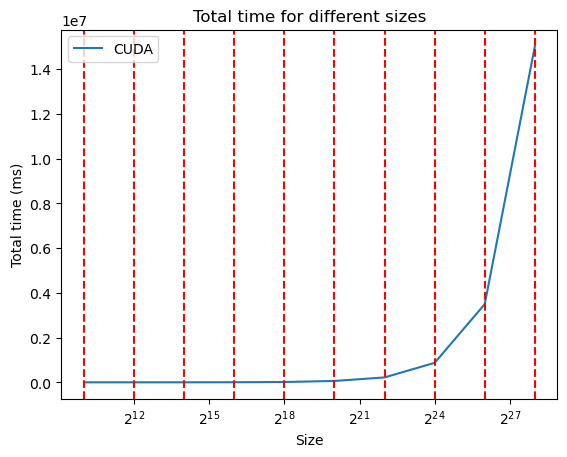

In [45]:
# plot avg total time for each size
# cpu_avg = cpu.groupby("size").mean()
# cl_avg = cl.groupby("size").mean()
cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
# ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
# ax.plot(cl_avg.index, cl_avg["total time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
# plot vertical isolines of power of 2
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

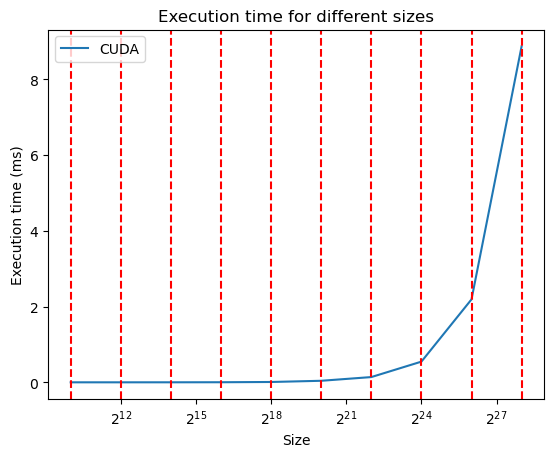

In [50]:
# plot avg execution time for each size
fig, ax = plt.subplots()
# ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
# ax.plot(cl_avg.index, cl_avg["execution time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["execution time"]/(10**6), label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (s)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()

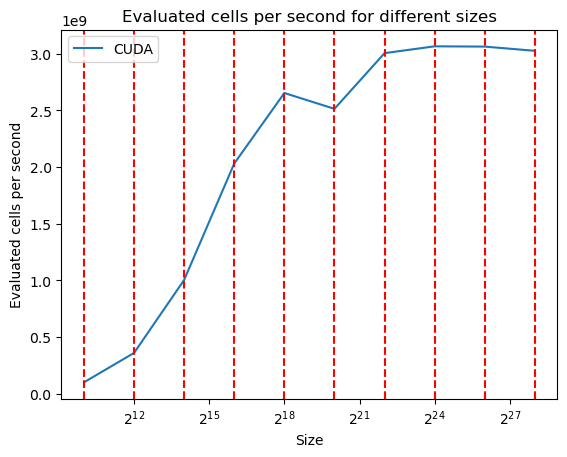

In [51]:
# plot evaluated cells per secod for each size

# cpu_avg["evaluated cells per second"] = cpu_avg.index*iterations / (cpu_avg["execution time"]/(10**6))
# cl_avg["evaluated cells per second"] = cl_avg.index*iterations / (cl_avg["execution time"]/(10**6))
cuda_avg["evaluated cells per second"] = cuda_avg.index*iterations / (cuda_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
# ax.plot(cpu_avg.index, cpu_avg["evaluated cells per second"], label="CPU")
# ax.plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()





In [28]:
# print speedup on execution time
speedup_cl = cpu_avg["execution time"] / cl_avg["execution time"]
speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup OpenCL")
print(speedup_cl)
print("Speedup CUDA")
print(speedup_cuda)

Speedup OpenCL
size
32            0.000000
64            0.000000
128           0.000000
256           0.500000
512           0.952381
1024          2.105263
2048          5.350000
4096          9.000000
8192         18.850000
16384        32.772727
32768        73.600000
65536       145.700000
131072      255.391304
262144      599.500000
524288     1183.400000
1048576    2248.761905
Name: execution time, dtype: float64
Speedup CUDA
size
32          0.000000
64          0.000000
128         0.000000
256         0.133333
512         0.273973
1024        0.476190
2048        1.337500
4096        2.222222
8192        4.833333
16384       8.901235
32768      11.590551
65536      12.141667
131072     13.200000
262144     13.532731
524288     27.425261
1048576    54.032037
Name: execution time, dtype: float64


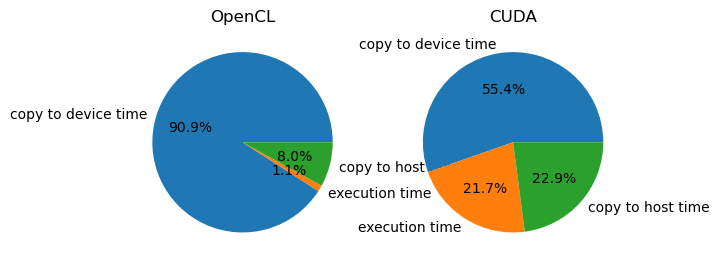

In [20]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()

### Conclusión
- Para arreglos de tamaño menor o igual a $2^{20}$ el rendimiento en CPU y GPU es similar
- Existen un gran speedup en *tiempo de ejecución* no asi en *tiempo total* del programa
- En OpenCL el mayor problema esta en el paso de memoria de CPU a GPU.
- En CUDA también se repite este problema pero esta más equilibrado.

## Experimento 3
Número de células evaluadas por segundo para varios tamaños de bloque

Variar el tamaño de `block/local size` con tamaño de grilla fijo $2^{20}$, 1000 iteraciones y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de bloque:
    
        - Primero usando 6 múltiplos de 32: 32, 64, 128, 256, 512, 1024
    
        - Luego usando 6 no múltiplos de 32: 48, 96, 192, 384, 768, 1536

In [ ]:
current_path = os.getcwd()
iterations = 1000
N = 2**10
M = 2**10

for i in range(32, 1025, 32):
    block = i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>    <output_file>               <0|1 (if)>
        # subprocess.run([CPU_EXEC,   str(N),         str(M),         iterations,     current_path + "/cpu.csv",  str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        # subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),              str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

for i in range(48, 1537, 48):
    block = i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>    <output_file>               <0|1 (if)>
        # subprocess.run([CPU_EXEC,   str(N),         str(M),         iterations,     current_path + "/cpu.csv",  str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        # subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),              str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

